In [14]:
import numpy as np
import matplotlib.pyplot as pp
# import scipy.linalg as la
%matplotlib inline

data = np.loadtxt(open("RegressionData.txt","rb"), delimiter=" ", skiprows=0)
# print data

X = data[:,0]  # random numbers x_n drawn from uniform distribution over [0,1]
print X
Y = data[:,1]  # labels/target values t_n for x_n, generated using 2*pi*x_n, gaussian noise with standard deviation sigma=0.25
print Y

[ 0.5503  0.9206  0.5359  0.6081  0.0202  0.8545  0.2357  0.4847  0.3996
  0.1957]
[-0.5894 -0.2507 -0.0468 -0.3402  0.2857 -1.0683  0.8605 -0.0801  0.6837
  1.185 ]


# 3.1

In [353]:
def init(X, layers=[1, 3, 1]):
    rows = np.max(layers)+1  # include bias node
    columns = len(layers)

    # activations, 3 columns: bias + input layer, 1 hidden layer, output layer
    S = np.zeros((rows, columns))
    
    # bias
    S[0,:] = -1.

    # connection weights W[from-layer][from-index, to-index]
    W = [np.random.uniform(-0.5, 0.5, rows*rows).reshape(rows, rows) for i in range(columns-1)]
    for w in range(len(W)):
        left = layers[w]  # max from-index
        right = layers[w+1]  # max to-index
        
        for i in range(rows):
            for j in range(rows):
                # only allow weights between nodes that exist in the model
                # may not come from too high index
                # may not go to too high index
                # may not go to bias node
                if i > left or j > right or j == 0:
                    W[w][i,j] = 0.
    
    # transfer fct
    f = np.tanh
    # 1st derivative of transfer fct
    fd = lambda h : (1./np.cosh(h))**2

    return S, W, f, fd

# calculate activations
def forward(S, W, X, f):
    rows, columns = S.shape
    
    for i,x in enumerate(X):
        # init
        H = np.zeros(S.shape)
        S[1:,0] = X.T
        H[1:,0] = X.T

        # propagation
        for v in range(1, columns):
            S[1:,v] = H[1:,v] = W[v-1].T.dot(S[:,v-1])[1:]
            if v < columns-1:
                S[1:,v] = f(H[1:,v])

    return H, S

# calculate output error as quadratic error
def output_error(Yt, Yx):  # target labels, computed labels
    return ((Yt-Yx)**2)/2.

# calculate local error for each training point
def backward(S, H, W, fd):
    rows, columns = S.shape
    
    # init
    D = np.zeros((rows, columns))
    D[1:,-1] = 1  # =1 if f = identity
    
    # propagate
    for v in range(columns-1)[::-1]:
        D[:,v] = fd(H[:,v]) * (D[:,v+1].T.dot(W[v]))
    
    return D

def gradient(S, D, Yt, Yx):
    rows, columns = S.shape
    # 1st factor as per script p. 17 (1.9)
    dedy = np.insert(Yx - Yt, 0, 0)  # row vector
    
    # 2nd factor as per script p. 18 (1.11)
    dydw = [D[:,i,np.newaxis] * S[:,i+1,np.newaxis].T for i in range(columns-1)]
    # dydw should now be a quadratic matrix indexed as dydw[from,to]
    
    # script p. 17 (1.8), (1.7)
    N = float(len(Yt))
    G = [np.sum(np.array([dydw[i] * e for e in dedy]), 0)/N for i in range(len(dydw))]
    
    return G

def weight_update(W, G, eta):
    for w in range(len(W)):
        W[w] = W[w] - eta*G[w]
    
    return W

def ex31(X, Yt, S, W, f, fd):
    training_error = []
    Ey_old = Yt*0
    i = 0
    while i < 3000:
        H, S = forward(S, W, X, f)

        Ey = output_error(Yt, S[1:,-1])

        D = backward(S, H, W, fd)

        G = gradient(S, D, Yt, S[1:,-1])

        eta = .5
        W = weight_update(W, G, eta)
        
        converged = np.all((np.abs((Ey - Ey_old)/Ey_old)) < 10.**-5)
        if converged:
            break
        else:
            training_error.append( np.mean(Ey) )
            i += 1
            Ey_old = Ey

    pp.plot(range(len(training_error)), training_error)
    pp.xlabel("iteration")
    pp.ylabel("output error mean")
    print S

# cache variables
_S, _W, _f, _fd = init(X)
ex31(X, Y, _S, _W, _f, _fd)

ValueError: could not broadcast input array from shape (10) into shape (3)

**(d)** It's easier to compute dE/dY, which is Yx-Yt in this case.

# 3.2
It's not possible to set a custom function without implementing forward and backwards methods yourself in pybrain, so we've used SigmoidLayer instead of f(h) = 1 + tanh(h).

stimulus min/max/mean 0.0 15.0 7.5
response min/max/mean 0.0 50.0 23.1161290323


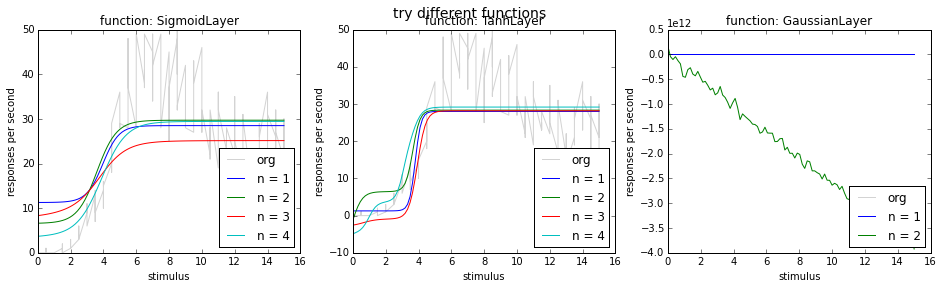

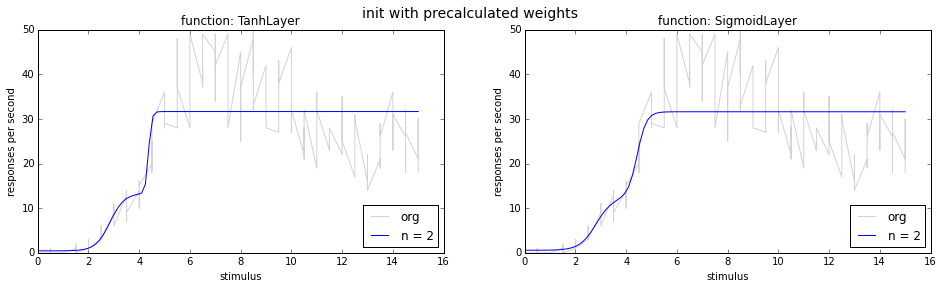

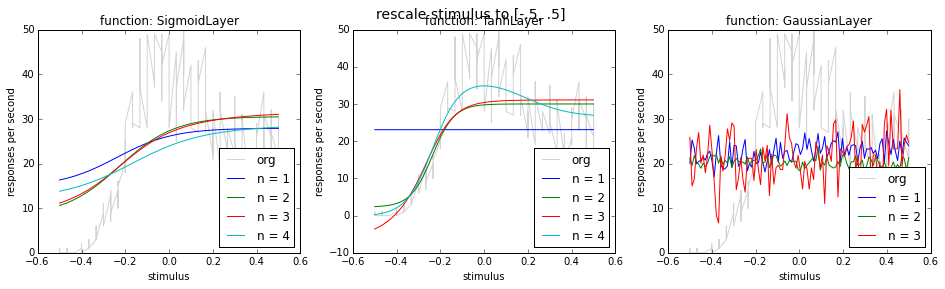

In [134]:
# 3.1 doesn't work, so we're using pybrain in this exercise (allowed by Timm)

# hello java
from pybrain.datasets import SupervisedDataSet
from pybrain.tools.shortcuts import buildNetwork
from pybrain.structure import FeedForwardNetwork, LinearLayer, TanhLayer, SigmoidLayer, GaussianLayer, FullConnection
from pybrain.supervised.trainers import BackpropTrainer

import pdb

def load_data():
    data = np.loadtxt(open("simulatedRFmapping.csv","rb"), delimiter=",", skiprows=1)
    # [(stimulus, responses per second), ...]
    S = data[:,0]
    R = data[:,1]
    print "stimulus min/max/mean", np.min(S), np.max(S), np.mean(S)
    print "response min/max/mean", np.min(R), np.max(R), np.mean(R)
    return data

def print_net(net):
    n = net
    for mod in n.modules:
        for conn in n.connections[mod]:
            print conn
            for cc in range(len(conn.params)):
                print conn.whichBuffers(cc), conn.params[cc]

def experiment(data, n_hidden, f, max_epochs=10, params=None):
    S = data[:,0]
    X = np.linspace(np.min(S), np.max(S), 100)
    Y = np.zeros((len(X), len(n_hidden)))
    
    for j,n in enumerate(n_hidden):
        # create network
        net = buildNetwork(1, n, 1, bias=True, hiddenclass=f, outclass=LinearLayer)

        if params:
            net._setParameters(np.array(params))
        
        dataset = SupervisedDataSet(1,1)
        for (x,y) in data:
            dataset.addSample(x,y)

        trainer = BackpropTrainer(net, dataset, learningrate=0.5/float(len(data)))
        trainer.trainUntilConvergence(trainingData=dataset, maxEpochs=max_epochs)
        
#         print_net(net)
        
        for i,x in enumerate(X):
            Y[i,j] = net.activate([x])
    
    pp.plot(data[:,0], data[:,1], color="lightgrey")
    pp.title("original data")
    
    pp.plot(X, Y)
    pp.xlabel("stimulus")
    pp.ylabel("responses per second")
    pp.legend(["org"] + ["n = "+str(n) for n in n_hidden], loc="lower right")
    pp.title("function: " + f.__name__)

def test():
    data = load_data()  # stimulus, responses per second
    n_hidden = [1,2,3,4]

    pp.figure(figsize=(16,4))
    pp.suptitle("try different functions", fontsize=14)
    pp.subplot(1,3,1)
    experiment(data, n_hidden, SigmoidLayer)
    pp.subplot(1,3,2)
    experiment(data, n_hidden, TanhLayer)
    pp.subplot(1,3,3)
    # n=4, n=3 ruins output scaling for GaussianLayer, so exclude it
    experiment(data, n_hidden[:2], GaussianLayer)
    
    # informed init
    n_hidden = [2]
    pp.figure(figsize=(16,4))
    pp.suptitle("init with precalculated weights", fontsize=14)
    # parameter array layout for n = 2
    # 1: bias -> out, 
    # 2: bias -> hidden0 0
    # 3: bias -> hidden0 1
    # 4: in -> hidden0 0
    # 5: in -> hidden0 1
    # 6: hidden0 -> out
    # 7: hidden0 -> out

    pp.subplot(1,2,1)
    params = [15.7434796202 , 5.0315701034 , -36.0447424956 , -1.85670312629 , 7.46272758188 , -6.17305731731 , 9.06131950296]
    experiment(data, n_hidden, TanhLayer, max_epochs=10, params=params)
    
    pp.subplot(1,2,2)
    params = [ 12.1802057683 , 8.77370892587 , -24.1171927629 , -3.20401883951 , 5.493887935 , -11.7027207948 , 18.8436906511 ]
    experiment(data, n_hidden, SigmoidLayer, max_epochs=10, params=params)
    
    # rescale stimulus
    S = data[:,0]
    S = S/np.max(S) - .5
    data[:,0] = S

    n_hidden = [1,2,3,4]

    pp.figure(figsize=(16,4))
    pp.suptitle("rescale stimulus to [-.5, .5]", fontsize=14)
    pp.subplot(1,3,1)
    experiment(data, n_hidden, SigmoidLayer)
    pp.subplot(1,3,2)
    experiment(data, n_hidden, TanhLayer)
    pp.subplot(1,3,3)
    experiment(data, n_hidden[:3], GaussianLayer)

    return

test()
